In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]) #normalize를 각 channel별로 해주었다.

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


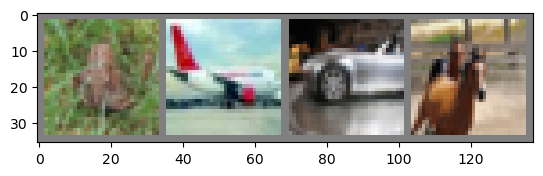

 frog  plane    car  horse 
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([6, 0, 1, 7])


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s ' % classes[labels[j]] for j in range(4)))

print(type(images), images.shape)
#batch_size, channels(RGB), height, width

print(type(labels), labels.shape, labels)

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        
        #n_layer 개수 만큼 hidden layers 추가
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        if act == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.ReLU()
    
    #관용적으로 클래스 내에서 함수와 함수사이는 한줄을 띄운다.        
    def forward(self, x):
        x = self.act(self.fc1(x))
        #fc에 nn.Linear가 바로 적용됨
        for fc in self.linears:
            x = self.act(fc(x))
        #*마지막 layer은 activation function을 거치지 않는 것이 좋음 -> classification 할 때 문제가 발생 할 수 있음
        x = self.fc2(x)
        return x

net = MLP(3072, 10, 100, 4, 'relu')
print(net)

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


In [5]:
def experiment(args):

    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda()
    print(net)

    criterion =  nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times

        # ==== Train ===== #
        net.train()
        
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

            # get the inputs
            inputs, labels = data
            inputs = inputs.view(-1, 3072) #MLP에 넣을거임.  * -1: 자동으로 설정됨
            inputs = inputs.cuda()
            labels = labels.cuda()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                

        # ==== Validation ====== #
        net.eval()
        # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
        
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = net(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
        
        print('Epoch {}, Train Loss: {:2.2f}, Val Loss: {:2.2f}, Val Acc: {}%'.format(epoch, train_loss, val_loss, val_acc ))


    # ===== Evaluation ===== #
    net.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
    return train_loss, val_loss, val_acc, test_acc
    

In [6]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 1e-3
args.mm = 0.9
args.epoch = 2


list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]



In [7]:
#seed를 세팅해놓으면 랜덤으로 추출하나 항상 같은 값이 나옴 
#*(hyperparameter tuning을 위해서 같은 지점의 출발점으로 세팅 [hyperparameter의 영향력을 알아보기 위함])
#numpy와 torch의 시드를 고정
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

#hyperparameter tuning
list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)

MLP(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.179
[1,  4000] loss: 1.880
[1,  6000] loss: 1.773
[1,  8000] loss: 1.729
[1, 10000] loss: 1.708
Epoch 0, Train Loss: 18537.75, Val Loss: 1.66, Val Acc: 40.07%
[2,  2000] loss: 1.631
[2,  4000] loss: 1.607
[2,  6000] loss: 1.600
[2,  8000] loss: 1.590
[2, 10000] loss: 1.569
Epoch 1, Train Loss: 15992.80, Val Loss: 1.56, Val Acc: 43.87%
(15992.796527504921, 1.561794221663475, 43.87, 44.94)
MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_